## Scott Breitbach
### DSC530: Week 7
### Assignment 7.2
### 15-October-2020

# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [118]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import brfss

import thinkstats2
import thinkplot

## Scatter plots

I'll start with the data from the BRFSS again.

In [119]:
df = brfss.ReadBrfss(nrows=None)

The following function selects a random subset of a `DataFrame`.

In [120]:
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

I'll extract the height in cm and the weight in kg of the respondents in the sample.

In [121]:
sample = SampleRows(df, 5000)
heights, weights = sample.htm3, sample.wtkg2

Here's a simple scatter plot with `alpha=1`, so each data point is fully saturated.

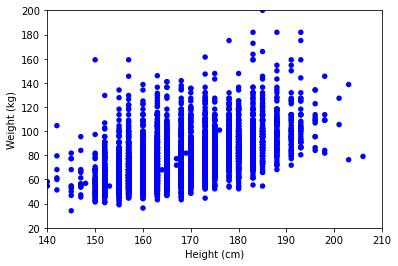

In [122]:
thinkplot.Scatter(heights, weights, alpha=1)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The data fall in obvious columns because they were rounded off.  We can reduce this visual artifact by adding some random noice to the data.

NOTE: The version of `Jitter` in the book uses noise with a uniform distribution.  Here I am using a normal distribution.  The normal distribution does a better job of blurring artifacts, but the uniform distribution might be more true to the data.

In [123]:
def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.normal(0, jitter, n) + values

Heights were probably rounded off to the nearest inch, which is 2.8 cm, so I'll add random values from -1.4 to 1.4.

In [124]:
heights = Jitter(heights, 1.4)
weights = Jitter(weights, 0.5)

And here's what the jittered data look like.

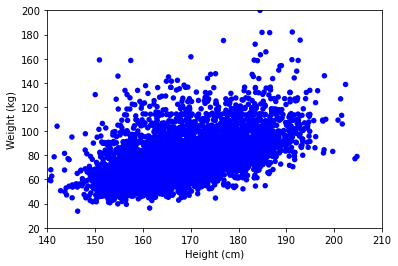

In [125]:
thinkplot.Scatter(heights, weights, alpha=1.0)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The columns are gone, but now we have a different problem: saturation.  Where there are many overlapping points, the plot is not as dark as it should be, which means that the outliers are darker than they should be, which gives the impression that the data are more scattered than they actually are.

This is a surprisingly common problem, even in papers published in peer-reviewed journals.

We can usually solve the saturation problem by adjusting `alpha` and the size of the markers, `s`.

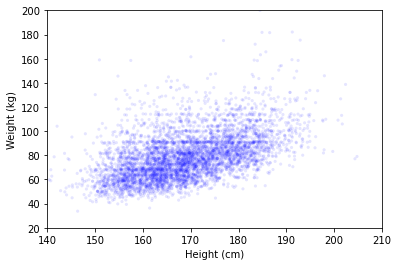

In [126]:
thinkplot.Scatter(heights, weights, alpha=0.1, s=10)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

That's better.  This version of the figure shows the location and shape of the distribution most accurately.  There are still some apparent columns and rows where, most likely, people reported their height and weight using rounded values.  If that effect is important, this figure makes it apparent; if it is not important, we could use more aggressive jittering to minimize it. 

An alternative to a scatter plot is something like a `HexBin` plot, which breaks the plane into bins, counts the number of respondents in each bin, and colors each bin in proportion to its count.

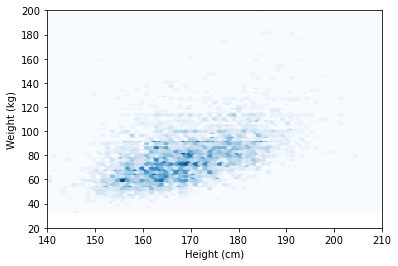

In [127]:
thinkplot.HexBin(heights, weights)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

In this case the binned plot does a pretty good job of showing the location and shape of the distribution.  It obscures the row and column effects, which may or may not be a good thing.

**Exercise:**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatterplot can be tricky.  As an exercise, experiment with `Scatter` and `HexBin` to make a plot that represents the entire dataset well.

In [128]:
sample = SampleRows(df, 414509)
heights, weights = sample.htm3, sample.wtkg2

In [129]:
heights = Jitter(heights, 2.8)
weights = Jitter(weights, 1)

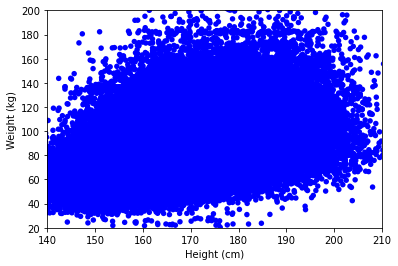

In [130]:
thinkplot.Scatter(heights, weights, alpha=1.0)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

In [ ]:
thinkplot.Scatter(heights, weights, alpha=0.01, s=2)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

In [ ]:
thinkplot.HexBin(heights, weights)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

## Plotting percentiles

Sometimes a better way to get a sense of the relationship between variables is to divide the dataset into groups using one variable, and then plot percentiles of the other variable.

First I'll drop any rows that are missing height or weight.

In [ ]:
cleaned = df.dropna(subset=['htm3', 'wtkg2'])

Then I'll divide the dataset into groups by height.

In [ ]:
bins = np.arange(135, 210, 5)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)

Here are the number of respondents in each group:

In [ ]:
for i, group in groups:
    print(i, len(group))

Now we can compute the CDF of weight within each group.

In [ ]:
mean_heights = [group.htm3.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

And then extract the 25th, 50th, and 75th percentile from each group.

In [ ]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_heights, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.  As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

In [ ]:
bins = np.arange(140, 210, 10)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)

In [ ]:
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

In [ ]:
thinkplot.PrePlot(len(cdfs))
thinkplot.Cdfs(cdfs)
thinkplot.Config(xlabel='Weight (kg)',
                 ylabel='CDF',
                 axis=[20, 200, 0, 1],
                 legend=False)

## Correlation

The following function computes the covariance of two variables using NumPy's `dot` function.

In [ ]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

And here's an example:

In [ ]:
heights, weights = cleaned.htm3, cleaned.wtkg2
Cov(heights, weights)

Covariance is useful for some calculations, but it doesn't mean much by itself.  The coefficient of correlation is a standardized version of covariance that is easier to interpret.

In [ ]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

The correlation of height and weight is about 0.51, which is a moderately strong correlation.

In [ ]:
Corr(heights, weights)

NumPy provides a function that computes correlations, too:

In [ ]:
np.corrcoef(heights, weights)

The result is a matrix with self-correlations on the diagonal (which are always 1), and cross-correlations on the off-diagonals (which are always symmetric).

Pearson's correlation is not robust in the presence of outliers, and it tends to underestimate the strength of non-linear relationships.

Spearman's correlation is more robust, and it can handle non-linear relationships as long as they are monotonic.  Here's a function that computes Spearman's correlation:

In [ ]:
import pandas as pd

def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return Corr(xranks, yranks)

For heights and weights, Spearman's correlation is a little higher:

In [ ]:
SpearmanCorr(heights, weights)

A Pandas `Series` provides a method that computes correlations, and it offers `spearman` as one of the options.

In [ ]:
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

The result is the same as for the one we wrote.

In [ ]:
SpearmanCorr(heights, weights)

An alternative to Spearman's correlation is to transform one or both of the variables in a way that makes the relationship closer to linear, and the compute Pearson's correlation.

In [ ]:
Corr(cleaned.htm3, np.log(cleaned.wtkg2))

## Exercises

### Exercise 7-1

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [ ]:
import first

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

In [ ]:
agepreg, totalwgt_lb = live.agepreg, live.totalwgt_lb

#### Make a scatter plot of birth weight versus mother’s age.

In [ ]:
thinkplot.Scatter(agepreg, totalwgt_lb, alpha=0.1, s=10)
thinkplot.Config(xlabel='Mothers Age',
                 ylabel='Birth Weight (lb)',
                 legend=False)

#### Plot percentiles of birth weight versus mother’s age.

In [ ]:
bins = np.arange(10, 50, 5)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

In [ ]:
mean_ages = [group.agepreg.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups]

In [ ]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_ages, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='Mothers Age',
                 ylabel='Birth Weight (lb))',
                 legend=True)

#### Compute Pearson’s and Spearman’s correlations.

In [ ]:
print("Pearson's correlation:", Corr(agepreg, totalwgt_lb))

In [ ]:
print("Spearman's correlation:", SpearmanCorr(agepreg, totalwgt_lb))

#### How would you characterize the relationship between these variables?

The scatterplot gives no clear indication of a correlation between the mother's age and the birth weight of the infant. Birth weight of babies appears to be pretty consistent, regardless of the age of the mother, though it does seem to show that there are particular ages at which mothers are more likely to give birth, with the most dense part of the cluster around 20 years of age.

The percentiles don't appear to show too much, except that the birth weight of 50th percentile seems to increase from around age 15 until around 25 or 30, at which point it levels off. 25th, 50th, and 75th percentiles all appear to decrease as the mother hits age 40.

The Pearson and Spearman correlations support this overal lack of a linear correlation, with values of ~0.07 and 0.09, respectively.

### Exercise 8-1

**Exercise:**  In this chapter we used $\bar{x}$ and median to estimate µ, and found that $\bar{x}$ yields lower MSE. Also, we used $S^2$ and $S_{n-1}^2$ to estimate σ, and found that $S^2$ is biased and $S_{n-1}^2$ unbiased.
Run similar experiments to see if $\bar{x}$ and median are biased estimates of µ. Also check whether $S^2$ or $S_{n-1}^2$ yields a lower MSE.

In [ ]:
def RMSE(estimates, actual):
    """Computes the root mean squared error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float RMSE
    """
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)

In [ ]:
import random

def VarEstMSE (n=7, iters=1000):
    """Evaluates RMSE of variance as estimators.
    
    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1
    
    estimates1 = []
    estimates2 = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)
    print('Experiment: Variance MSE')
    print('RMSE biased', RMSE(estimates1, sigma**2))
    print('RMSE unbiased', RMSE(estimates2, sigma**2))

VarEstMSE()

In [ ]:
def MeanError(estimates, actual):
    """Computes the mean error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float mean error
    """
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

In [ ]:
def MeanMedBias(n=7, iters=1000):
    mu = 0
    sigma = 1
    
    means = []
    medians = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for _ in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)
    
    print('Experiment: xbar, median bias')
    print('mean error xbar', MeanError(means, mu))
    print('mean error median', MeanError(medians, mu))

MeanMedBias()

### Exercise 8-2

**Exercise:** Suppose you draw a sample with size n=10 from an exponential distribution with λ=2. Simulate this experiment 1000 times and plot the sampling distribution of the estimate L. Compute the standard error of the estimate and the 90% confidence interval.

Repeat the experiment with a few different values of `n` and make a plot of standard error versus `n`.



In [ ]:
def SampleSim(n=10, lam=2, iters=1000):
    """Simulate sampling distribution of estimate L.
    Compute standard error of estimate.
    Compute 90% CI.
    """
    
    estimates = []
    for _ in range(iters):
        xs = np.random.exponential(1/lam, n)
        L = 1 / np.mean(xs)
        estimates.append(L)
    
    print('Experiment: Sampling distribution with estimate "L"')
    stdError = RMSE(estimates, lam)
    print('Standard Error (n=10):', stdError)
    
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    print('90% Confidence Interval', ci)
    
    thinkplot.Cdf(cdf)
    print('CDF Plot:')
    thinkplot.Config(xlabel='"L" Estimate',
                     ylabel='CDF',
                     title='Sampling Distribution')

    return stdError

se10 = SampleSim()

In [ ]:
def SampleSim(n=100, lam=2, iters=1000):
    """Simulate sampling distribution of estimate L.
    Compute standard error of estimate.
    Compute 90% CI.
    """
    
    estimates = []
    for _ in range(iters):
        xs = np.random.exponential(1/lam, n)
        L = 1 / np.mean(xs)
        estimates.append(L)
    
    print('Experiment: Sampling distribution with estimate "L"')
    stdError = RMSE(estimates, lam)
    print('Standard Error (n=10):', stdError)
    
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    print('90% Confidence Interval', ci)
    
    thinkplot.Cdf(cdf)
    print('CDF Plot:')
    thinkplot.Config(xlabel='"L" Estimate',
                     ylabel='CDF',
                     title='Sampling Distribution')

    return stdError

se100 = SampleSim()

In [ ]:
def SampleSim(n=1000, lam=2, iters=1000):
    """Simulate sampling distribution of estimate L.
    Compute standard error of estimate.
    Compute 90% CI.
    """
    
    estimates = []
    for _ in range(iters):
        xs = np.random.exponential(1/lam, n)
        L = 1 / np.mean(xs)
        estimates.append(L)
    
    print('Experiment: Sampling distribution with estimate "L"')
    stdError = RMSE(estimates, lam)
    print('Standard Error (n=10):', stdError)
    
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    print('90% Confidence Interval', ci)
    
    thinkplot.Cdf(cdf)
    print('CDF Plot:')
    thinkplot.Config(xlabel='"L" Estimate',
                     ylabel='CDF',
                     title='Sampling Distribution')

    return stdError

se1000 = SampleSim()

In [ ]:
print('SE for n=10:', se10)
print('SE for n=100:', se100)
print('SE for n=1000:', se1000)

n = [10, 100, 1000]
se = [se10, se100, se1000]

thinkplot.scatter(n, se)

In [ ]:
logn = np.log(n)

thinkplot.scatter(logn, se)

Standard Error approaches zero as n increases.